<h2>Quadratic Regression Dataset - Linear Regression vs XGBoost</h2>

Model is trained with XGBoost installed in notebook instance

In the later examples, we will train using SageMaker's XGBoost algorithm.

Training on SageMaker takes several minutes (even for simple dataset).  

If algorithm is supported on Python, we will try them locally on notebook instance

This allows us to quickly learn an algorithm, understand tuning options and then finally train on SageMaker Cloud

In this exercise, let's compare XGBoost and Linear Regression for Quadratic regression dataset

In [1]:
# Install xgboost in notebook instance.
#### Command to install xgboost
!pip install xgboost==0.90

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


# XGBoost 
import xgboost as xgb
# Linear Regression
from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv('quadratic_all.csv')

In [4]:
df.head()

,x,y
0,-20.0,2473.236825
1,-19.8,2405.673895
2,-19.6,2444.523136
3,-19.4,2320.437236
4,-19.2,2288.088295


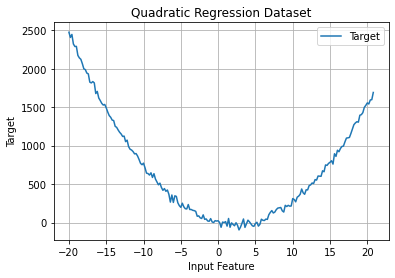

In [5]:
plt.plot(df.x,df.y,label='Target')
plt.grid(True)
plt.xlabel('Input Feature')
plt.ylabel('Target')
plt.legend()
plt.title('Quadratic Regression Dataset')
plt.show()

In [6]:
train_file = 'quadratic_train.csv'
validation_file = 'quadratic_validation.csv'

# Specify the column names as the file does not have column header
df_train = pd.read_csv(train_file,names=['y','x'])
df_validation = pd.read_csv(validation_file,names=['y','x'])

In [7]:
df_train.head()

,y,x
0,343.968005,10.8
1,1585.894405,-15.8
2,1497.303317,19.6
3,769.909912,-10.4
4,1173.230755,-13.2


In [8]:
df_validation.head()

,y,x
0,1824.856344,-17.2
1,16.997917,-1.2
2,1832.141730,-16.8
3,1395.206684,19.0
4,145.840543,-3.0


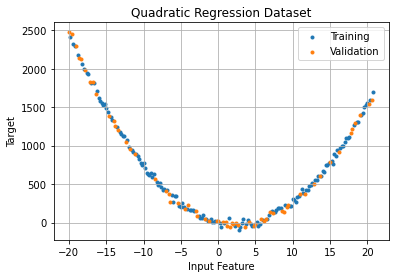

In [9]:
plt.scatter(df_train.x,df_train.y,label='Training',marker='.')
plt.scatter(df_validation.x,df_validation.y,label='Validation',marker='.')
plt.grid(True)
plt.xlabel('Input Feature')
plt.ylabel('Target')
plt.title('Quadratic Regression Dataset')
plt.legend()
plt.show()

In [10]:
X_train = df_train.iloc[:,1:] # Features: 1st column onwards 
y_train = df_train.iloc[:,0].ravel() # Target: 0th column

X_validation = df_validation.iloc[:,1:]
y_validation = df_validation.iloc[:,0].ravel()

In [11]:
# Create an instance of XGBoost Regressor
# XGBoost Training Parameter Reference: 
#   https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
regressor = xgb.XGBRegressor()

In [12]:
regressor

XGBRegressor()

In [13]:
regressor.fit(X_train,y_train, eval_set = [(X_train, y_train), (X_validation, y_validation)])

[18:37:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:852.082	validation_1-rmse:931.882
[1]	validation_0-rmse:776.32	validation_1-rmse:853.857
[2]	validation_0-rmse:707.455	validation_1-rmse:779.725
[3]	validation_0-rmse:644.955	validation_1-rmse:711.567
[4]	validation_0-rmse:587.747	validation_1-rmse:652.779
[5]	validation_0-rmse:536.019	validation_1-rmse:595.832
[6]	validation_0-rmse:490.469	validation_1-rmse:545.727
[7]	validation_0-rmse:447.317	validation_1-rmse:499.978
[8]	validation_0-rmse:410.19	validation_1-rmse:460.088
[9]	validation_0-rmse:374.376	validation_1-rmse:421.358
[10]	validation_0-rmse:342.484	validation_1-rmse:387.917
[11]	validation_0-rmse:313.615	validation_1-rmse:357.32
[12]	validation_0-rmse:286.623	validation_1-rmse:328.889
[13]	validation_0-rmse:263.527	validation_1-rmse:303.867
[14]	validation_0-rmse:241.564	validation_1-rmse:280.437
[15]	validation_0-rmse:220.987	

XGBRegressor()

In [14]:
eval_result = regressor.evals_result()

In [15]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

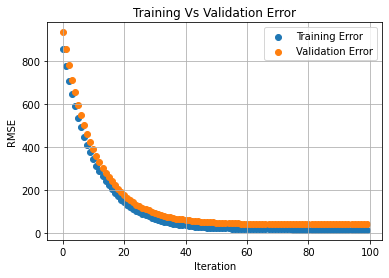

In [16]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

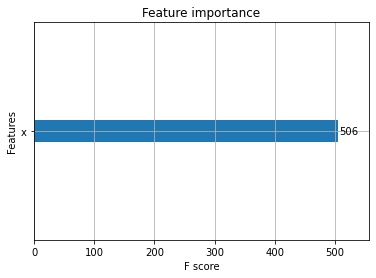

In [17]:
xgb.plot_importance(regressor)
plt.show()

## Validation Dataset Compare Actual and Predicted

In [18]:
result = regressor.predict(X_validation)

In [19]:
result[:5]

array([1816.5542  ,   35.690365, 1816.5542  , 1403.2208  ,  152.6108  ],
      dtype=float32)

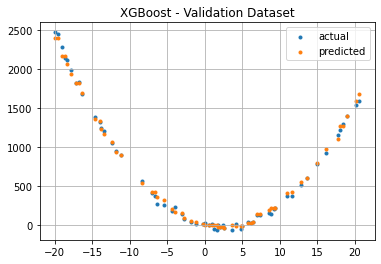

In [20]:
plt.title('XGBoost - Validation Dataset')
plt.scatter(df_validation.x,df_validation.y,label='actual',marker='.')
plt.scatter(df_validation.x,result,label='predicted',marker='.')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
# RMSE Metrics
print('XGBoost Algorithm Metrics')
mse = mean_squared_error(df_validation.y,result)
print(" Mean Squared Error: {0:.2f}".format(mse))
print(" Root Mean Square Error: {0:.2f}".format(mse**.5))

XGBoost Algorithm Metrics
 Mean Squared Error: 1679.40
 Root Mean Square Error: 40.98


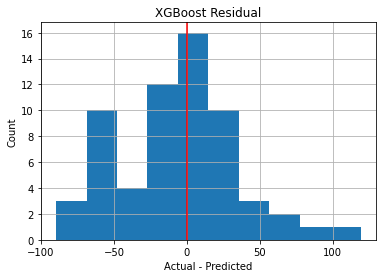

In [22]:
# Residual
# Over prediction and Under Prediction needs to be balanced
# Training Data Residuals
residuals = df_validation.y - result
plt.hist(residuals)
plt.grid(True)
plt.xlabel('Actual - Predicted')
plt.ylabel('Count')
plt.title('XGBoost Residual')
plt.axvline(color='r')
plt.show()

In [23]:
# Count number of values greater than zero and less than zero
value_counts = (residuals > 0).value_counts(sort=False)

print(' Under Estimation: {0}'.format(value_counts[True]))
print(' Over  Estimation: {0}'.format(value_counts[False]))

 Under Estimation: 29
 Over  Estimation: 33


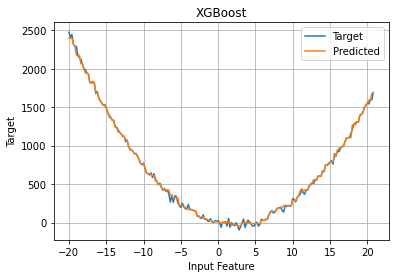

In [24]:
# Plot for entire dataset
plt.plot(df.x,df.y,label='Target')
plt.plot(df.x,regressor.predict(df[['x']]) ,label='Predicted')
plt.grid(True)
plt.xlabel('Input Feature')
plt.ylabel('Target')
plt.legend()
plt.title('XGBoost')
plt.show()

## Linear Regression Algorithm

In [25]:
lin_regressor = LinearRegression()

In [26]:
lin_regressor.fit(X_train,y_train)

LinearRegression()

Compare Weights assigned by Linear Regression.

Original Function: 5*x**2 -23*x + 47 + some noise

Linear Regression Function: -15.08 * x + 709.86 

Linear Regression Coefficients and Intercepts are not close to actual

In [27]:
lin_regressor.coef_

array([-15.07800272])

In [28]:
lin_regressor.intercept_

709.8622001903116

In [29]:
result = lin_regressor.predict(df_validation[['x']])

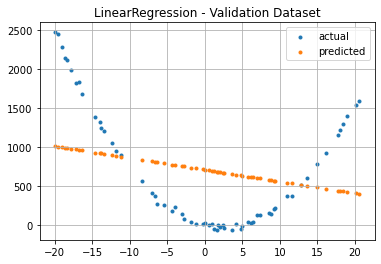

In [30]:
plt.title('LinearRegression - Validation Dataset')
plt.scatter(df_validation.x,df_validation.y,label='actual',marker='.')
plt.scatter(df_validation.x,result,label='predicted',marker='.')
plt.grid(True)
plt.legend()
plt.show()

In [31]:
# RMSE Metrics
print('Linear Regression Metrics')
mse = mean_squared_error(df_validation.y,result)
print(" Mean Squared Error: {0:.2f}".format(mse))
print(" Root Mean Square Error: {0:.2f}".format(mse**.5))

Linear Regression Metrics
 Mean Squared Error: 488269.59
 Root Mean Square Error: 698.76


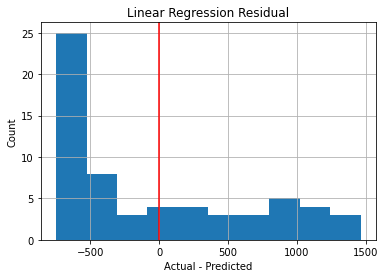

In [32]:
# Residual
# Over prediction and Under Prediction needs to be balanced
# Training Data Residuals
residuals = df_validation.y - result
plt.hist(residuals)
plt.grid(True)
plt.xlabel('Actual - Predicted')
plt.ylabel('Count')
plt.title('Linear Regression Residual')
plt.axvline(color='r')
plt.show()

In [33]:
# Count number of values greater than zero and less than zero
value_counts = (residuals > 0).value_counts(sort=False)

print(' Under Estimation: {0}'.format(value_counts[True]))
print(' Over  Estimation: {0}'.format(value_counts[False]))

 Under Estimation: 25
 Over  Estimation: 37


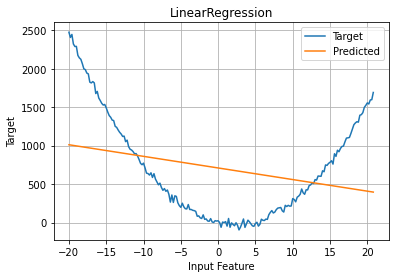

In [34]:
# Plot for entire dataset
plt.plot(df.x,df.y,label='Target')
plt.plot(df.x,lin_regressor.predict(df[['x']]) ,label='Predicted')
plt.grid(True)
plt.xlabel('Input Feature')
plt.ylabel('Target')
plt.legend()
plt.title('LinearRegression')
plt.show()

Linear Regression is showing clear symptoms of under-fitting

Input Features are not sufficient to capture complex relationship

<h2>Your Turn</h2>
You can correct this under-fitting issue by adding relavant features.

1. What feature will you add and why?
2. Complete the code and Test
3. What performance do you see now?

In [35]:
# Specify the column names as the file does not have column header
df_train = pd.read_csv(train_file,names=['y','x'])
df_validation = pd.read_csv(validation_file,names=['y','x'])
df = pd.read_csv('quadratic_all.csv')

# Add new features 

In [36]:
# Place holder to add new features to df_train, df_validation and df
# if you need help, scroll down to see the answer
# Add your code

In [37]:
df_train['x2'] = df_train['x']**2

In [38]:
df_validation['x2'] = df_validation['x']**2

In [39]:
df['x2'] = df['x']**2

In [40]:
X_train = df_train.iloc[:,1:] # Features: 1st column onwards 
y_train = df_train.iloc[:,0].ravel() # Target: 0th column

X_validation = df_validation.iloc[:,1:]
y_validation = df_validation.iloc[:,0].ravel()

In [41]:
lin_regressor.fit(X_train,y_train)

LinearRegression()

Original Function: -23*x + 5*x**2 + 47 + some noise (rewritten with x term first)

In [42]:
lin_regressor.coef_

array([-22.98286274,   4.98161803])

In [43]:
lin_regressor.intercept_

5.86810755251679

In [44]:
result = lin_regressor.predict(X_validation)

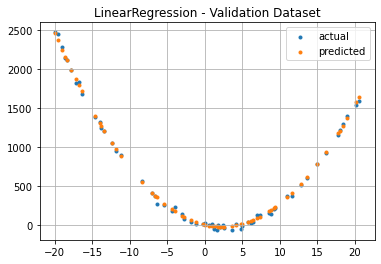

In [45]:
plt.title('LinearRegression - Validation Dataset')
plt.scatter(df_validation.x,df_validation.y,label='actual',marker='.')
plt.scatter(df_validation.x,result,label='predicted',marker='.')
plt.grid(True)
plt.legend()
plt.show()

In [46]:
# RMSE Metrics
print('Linear Regression Metrics')
mse = mean_squared_error(df_validation.y,result)
print(" Mean Squared Error: {0:.2f}".format(mse))
print(" Root Mean Square Error: {0:.2f}".format(mse**.5))

print("***You should see an RMSE score of 30.45 or less")

Linear Regression Metrics
 Mean Squared Error: 927.22
 Root Mean Square Error: 30.45
***You should see an RMSE score of 30.45 or less


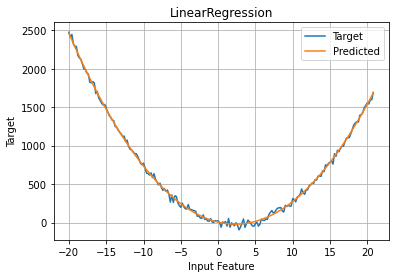

In [47]:
# Plot for entire dataset
plt.plot(df.x,df.y,label='Target')
plt.plot(df.x,lin_regressor.predict(df[['x','x2']]) ,label='Predicted')
plt.grid(True)
plt.xlabel('Input Feature')
plt.ylabel('Target')
plt.legend()
plt.title('LinearRegression')
plt.show()

## Solution for under-fitting

add a new X**2 term to the dataframe

syntax:

df_train['x2'] = df_train['x']**2

df_validation['x2'] = df_validation['x']**2

df['x2'] = df['x']**2

### Tree Based Algorithms have a lower bound and upper bound for predicted values

In [48]:
# True Function
def quad_func (x):
    return 5*x**2 -23*x + 47

In [49]:
# X is outside range of training samples
# New Feature: Adding X^2 term

X = np.array([-100,-25,25,1000,5000])
y = quad_func(X)
df_tmp = pd.DataFrame({'x':X,'y':y,'x2':X**2})
df_tmp['xgboost']=regressor.predict(df_tmp[['x']])
df_tmp['linear']=lin_regressor.predict(df_tmp[['x','x2']])

In [50]:
df_tmp

,x,y,x2,xgboost,linear
0,-100,52347,10000,2394.655029,5.212033e+04
1,-25,3747,625,2394.655029,3.693951e+03
2,25,2597,625,1679.101318,2.544808e+03
3,1000,4977047,1000000,1679.101318,4.958641e+06
4,5000,124885047,25000000,1679.101318,1.244255e+08


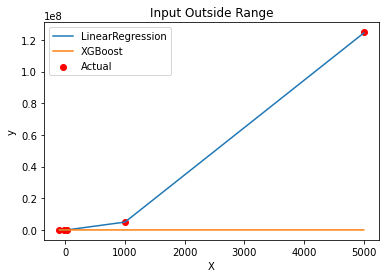

In [164]:
plt.scatter(df_tmp.x,df_tmp.y,label='Actual',color='r')
plt.plot(df_tmp.x,df_tmp.linear,label='LinearRegression')
plt.plot(df_tmp.x,df_tmp.xgboost,label='XGBoost')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Input Outside Range')
plt.show()

In [165]:
# X is inside range of training samples
X = np.array([-15,-12,-5,0,1,3,5,7,9,11,15,18])
y = quad_func(X)
df_tmp = pd.DataFrame({'x':X,'y':y,'x2':X**2})
df_tmp['xgboost']=regressor.predict(df_tmp[['x']])
df_tmp['linear']=lin_regressor.predict(df_tmp[['x','x2']])

In [166]:
df_tmp

,x,y,x2,xgboost,linear
0,-15,1517,225,1494.449585,1471.475106
1,-12,1043,144,991.589172,999.015457
2,-5,287,25,224.711700,245.322872
3,0,47,0,0.857939,5.868108
4,1,29,1,-2.623439,-12.133137
5,3,23,9,-42.854942,-18.245918
6,5,57,25,-12.994375,15.494245
7,7,131,49,144.216553,89.087352
8,9,245,81,220.426697,202.533404
9,11,399,121,416.157166,355.832399


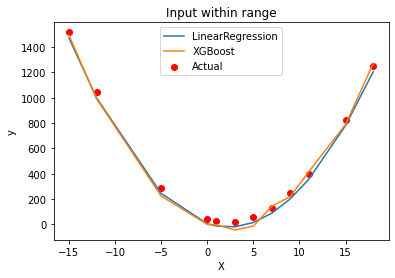

In [167]:
# XGBoost Predictions have an upper bound and lower bound
# Linear Regression Extrapolates
plt.scatter(df_tmp.x,df_tmp.y,label='Actual',color='r')
plt.plot(df_tmp.x,df_tmp.linear,label='LinearRegression')
plt.plot(df_tmp.x,df_tmp.xgboost,label='XGBoost')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Input within range')
plt.show()

<h2>Summary</h2>

1. In this exercise, we compared performance of XGBoost model and Linear Regression on a quadratic dataset
2. The relationship between input feature and target was non-linear.
3. XGBoost handled it pretty well; whereas, linear regression was under-fitting
4. To correct the issue, we had to add additional features for linear regression
5. With this change, linear regression performed much better

XGBoost can detect patterns involving non-linear relationship; whereas, algorithms like linear regression may need complex feature engineering